<a href="https://colab.research.google.com/github/dbrisaro/prueba-oposicion-risaro/blob/main/TP_flujos_calor_sal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Flujos de calor y de sal

Realizado por Daniela Belén Risaro para la prueba de oposición del cargo de JTP en el DCAO, FCEyN, UBA.

12 de diciembre de 2022

Esta rutina ayuda a visualizar los flujos de calor y de sal que ocurren en el océano a escala global. Mayormente vamos a estudiar los flujos a través de la superficie del océano, es decir los intercambios entre aire-agua.

La rutina puede ser ejecutada por cualquier estudiante que asi lo requiera si es que tiene conocimientos previos de programación. De lo contrario, puede utilizarse sin correr cada celda de la rutina, solo analizando las figuras y la información descripta en el siguiente notebook.



---



Si se desea ejectutar la rutina, correr las siguientes lineas una sola vez para instalar las dependencias necesarias

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install unlzw3
!pip install geoviews
!pip install pyproj

In [ ]:
!pip uninstall shapely
!pip install shapely --no-binary shapely

Importamos las librerías necesarias para correr la rutina

In [6]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pooch
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15,9)
plt.rcParams['font.size'] = 16

## Flujos de calor

Cargamos los datos necesarios para visualizar los flujos de calor


In [7]:
registry = {
    "hfns11a.nc.Z": None,
    "hfls11a.nc.Z": None,
    "hfss11a.nc.Z": None,
    "rss11a.nc.Z": None,
    "rls11a.nc.Z": None
}
POOCH = pooch.create(
    path=pooch.os_cache("Grist_Josey_2003"),
    base_url="ftp://ftp.noc.soton.ac.uk/pub/sxj/clim/netcdf/",
    registry=registry
)

fnames = {fname: POOCH.fetch(fname) for fname in registry}

In [8]:
import unlzw3
def uncompress(input_fname):
    assert input_fname[-2:] == '.Z'
    output_fname = input_fname[:-2]
    with open(input_fname, "rb") as fp:
        uncompressed_data = unlzw3.unlzw(fp.read())
    with open(output_fname, "wb") as fp:
        fp.write(uncompressed_data)
    return output_fname

fnames_uncompressed = [uncompress(f) for f in fnames.values()]

In [9]:
noca = xr.open_mfdataset(fnames_uncompressed, combine='by_coords')
noca = noca.assign_coords({'month': noca.time.dt.month}).swap_dims({'time': 'month'})
noca

<xarray.Dataset>
Dimensions:    (month: 12, longitude: 360, latitude: 170)
Coordinates:
    time       (month) object 0002-01-01 00:00:00 ... 0002-12-01 00:00:00
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -84.5 -83.5 -82.5 -81.5 ... 82.5 83.5 84.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    hfls11a    (month, latitude, longitude) float32 dask.array<chunksize=(12, 170, 360), meta=np.ndarray>
    hfns11a    (month, latitude, longitude) float32 dask.array<chunksize=(12, 170, 360), meta=np.ndarray>
    hfss11a    (month, latitude, longitude) float32 dask.array<chunksize=(12, 170, 360), meta=np.ndarray>
    rls11a     (month, latitude, longitude) float32 dask.array<chunksize=(12, 170, 360), meta=np.ndarray>
    rss11a     (month, latitude, longitude) float32 dask.array<chunksize=(12, 170, 360), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    calendar:     standard
    comments:     Climatological estimate based on ship meteorological report...
    model:        
    center:       National Oceanography Centre, Southampton, UK

### Flujo de radiación de onda corta
Este término es la radiación de onda corta entrante a la superficie del océano. Se encuentra en unidades de W/m$^2$. Los datos están disponibles para todo el globo y para los 12 meses del año. Para analizar el promedio anual, vamos a sumar el valor de todos los meses y dividirlo por la cantidad de los mismos. De esta manera, nos quedamos con un mapa promedio de todo el año.

In [10]:
q_onda_corta = noca.rss11a.mean(dim='month')

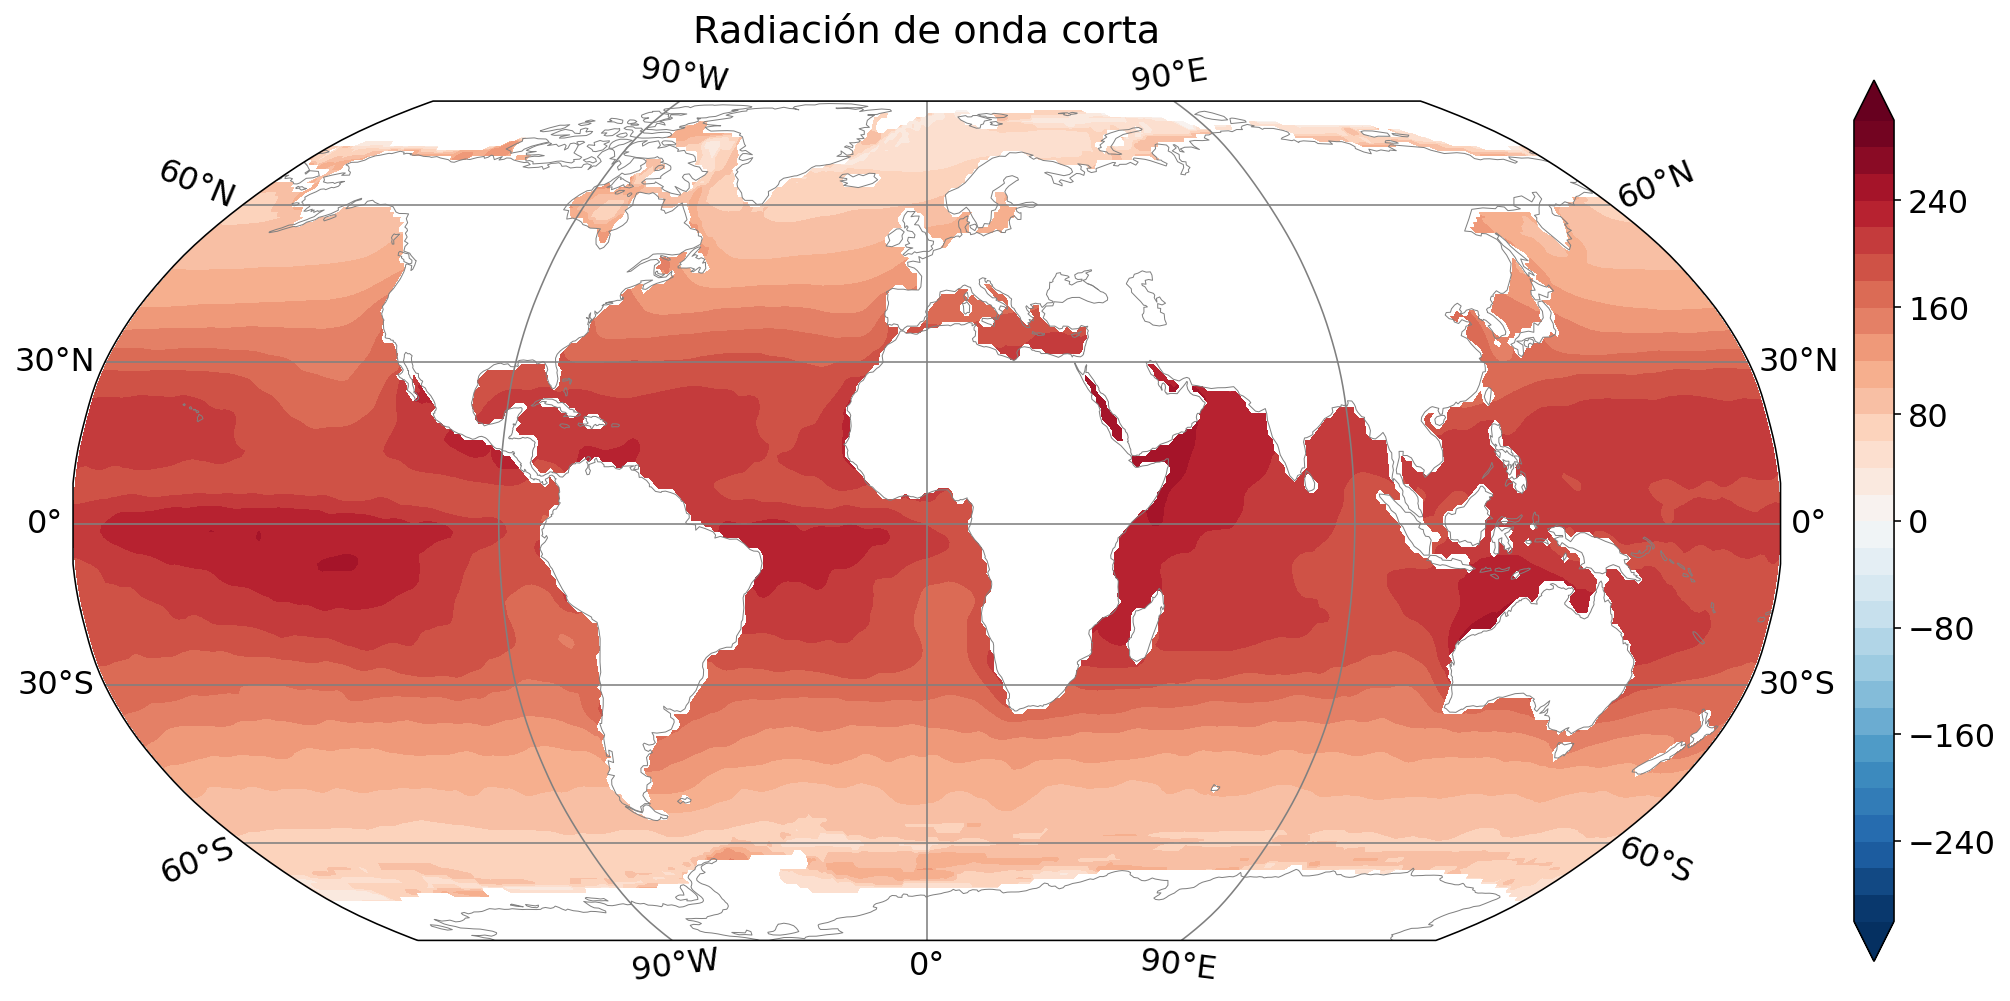

In [11]:
lon = q_onda_corta.longitude
lat = q_onda_corta.latitude
values = q_onda_corta.values
clevs = np.linspace(-300, 300, 31)
crs_latlon = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=ccrs.Robinson())
qplot = ax.contourf(lon, lat, values, cmap='RdBu_r', levels=clevs, transform=crs_latlon, extend='both')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5, color='gray')
grd = ax.gridlines(
    draw_labels=True, 
    xlocs=range(-180, 181, 90), 
    ylocs=range(-60, 61, 30), 
    color='gray',
)
grd.top_labels = False
ax.set_title('Radiación de onda corta')
plt.colorbar(qplot, fraction=0.03, pad=0.04, shrink=0.8, aspect=20)

### Flujo de radiación de onda larga
Este término es la radiación entrante a la superficie del océano de onda corta. Se encuentra en unidades de W/m$^2$. Los datos están disponibles para todo el globo y para los 12 meses del año. Para analizar el promedio anual, vamos a sumar el valor de todos los meses y dividirlo por la cantidad de los mismos. De esta manera, nos quedamos con un mapa promedio de todo el año.

In [12]:
q_onda_larga = noca.rls11a.mean(dim='month')

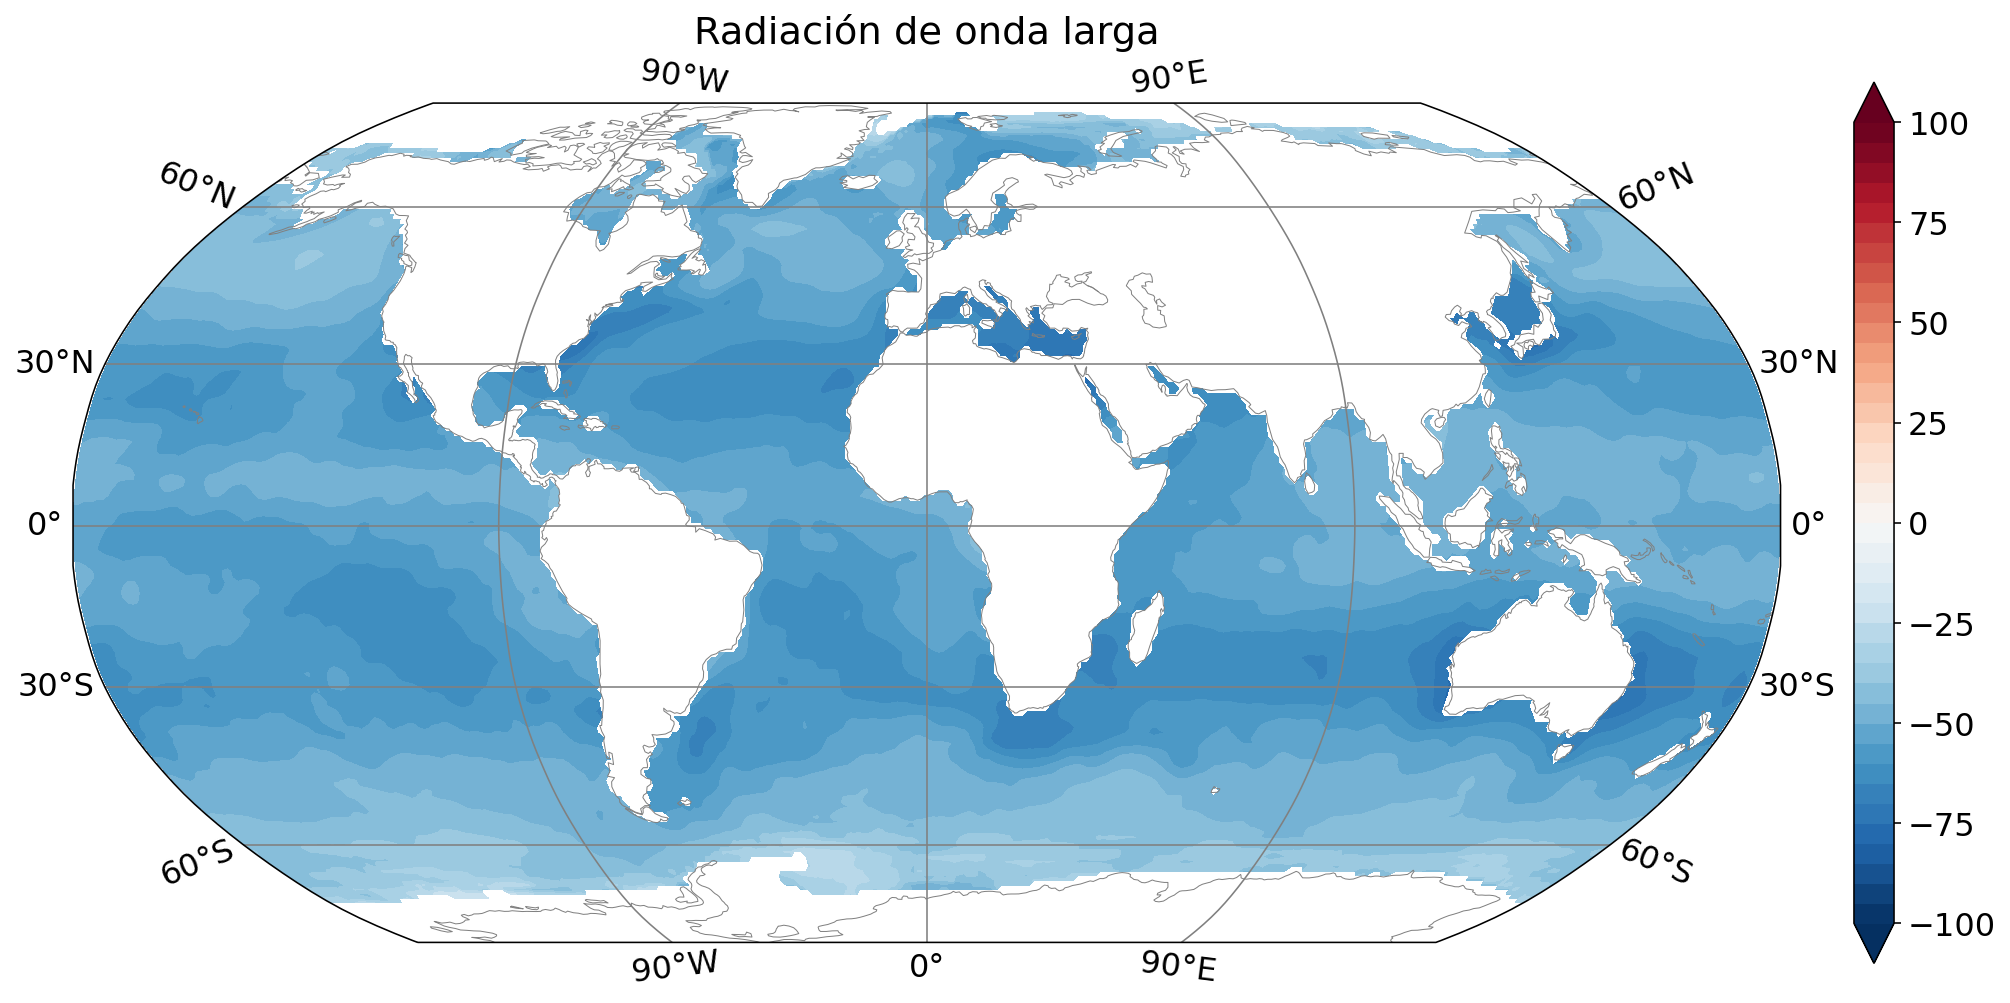

In [13]:
lon = q_onda_larga.longitude
lat = q_onda_larga.latitude
values = q_onda_larga.values
clevs = np.linspace(-100, 100, 41)
crs_latlon = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=ccrs.Robinson())
qplot = ax.contourf(lon, lat, values, cmap='RdBu_r', levels=clevs, transform=crs_latlon, extend='both')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5, color='gray')
grd = ax.gridlines(
    draw_labels=True, 
    xlocs=range(-180, 181, 90), 
    ylocs=range(-60, 61, 30), 
    color='gray',
)
grd.top_labels = False
ax.set_title('Radiación de onda larga')
plt.colorbar(qplot, fraction=0.03, pad=0.04, shrink=0.8, aspect=20)

### Flujo de calor sensible
Este término es el flujo de calor sensible que ingresa en la superficie del océano. Se encuentra en unidades de W/m$^2$. Los datos están disponibles para todo el globo y para los 12 meses del año. Para analizar el promedio anual, vamos a sumar el valor de todos los meses y dividirlo por la cantidad de los mismos. De esta manera, nos quedamos con un mapa promedio de todo el año.

In [14]:
q_sensible = noca.hfss11a.mean(dim='month')

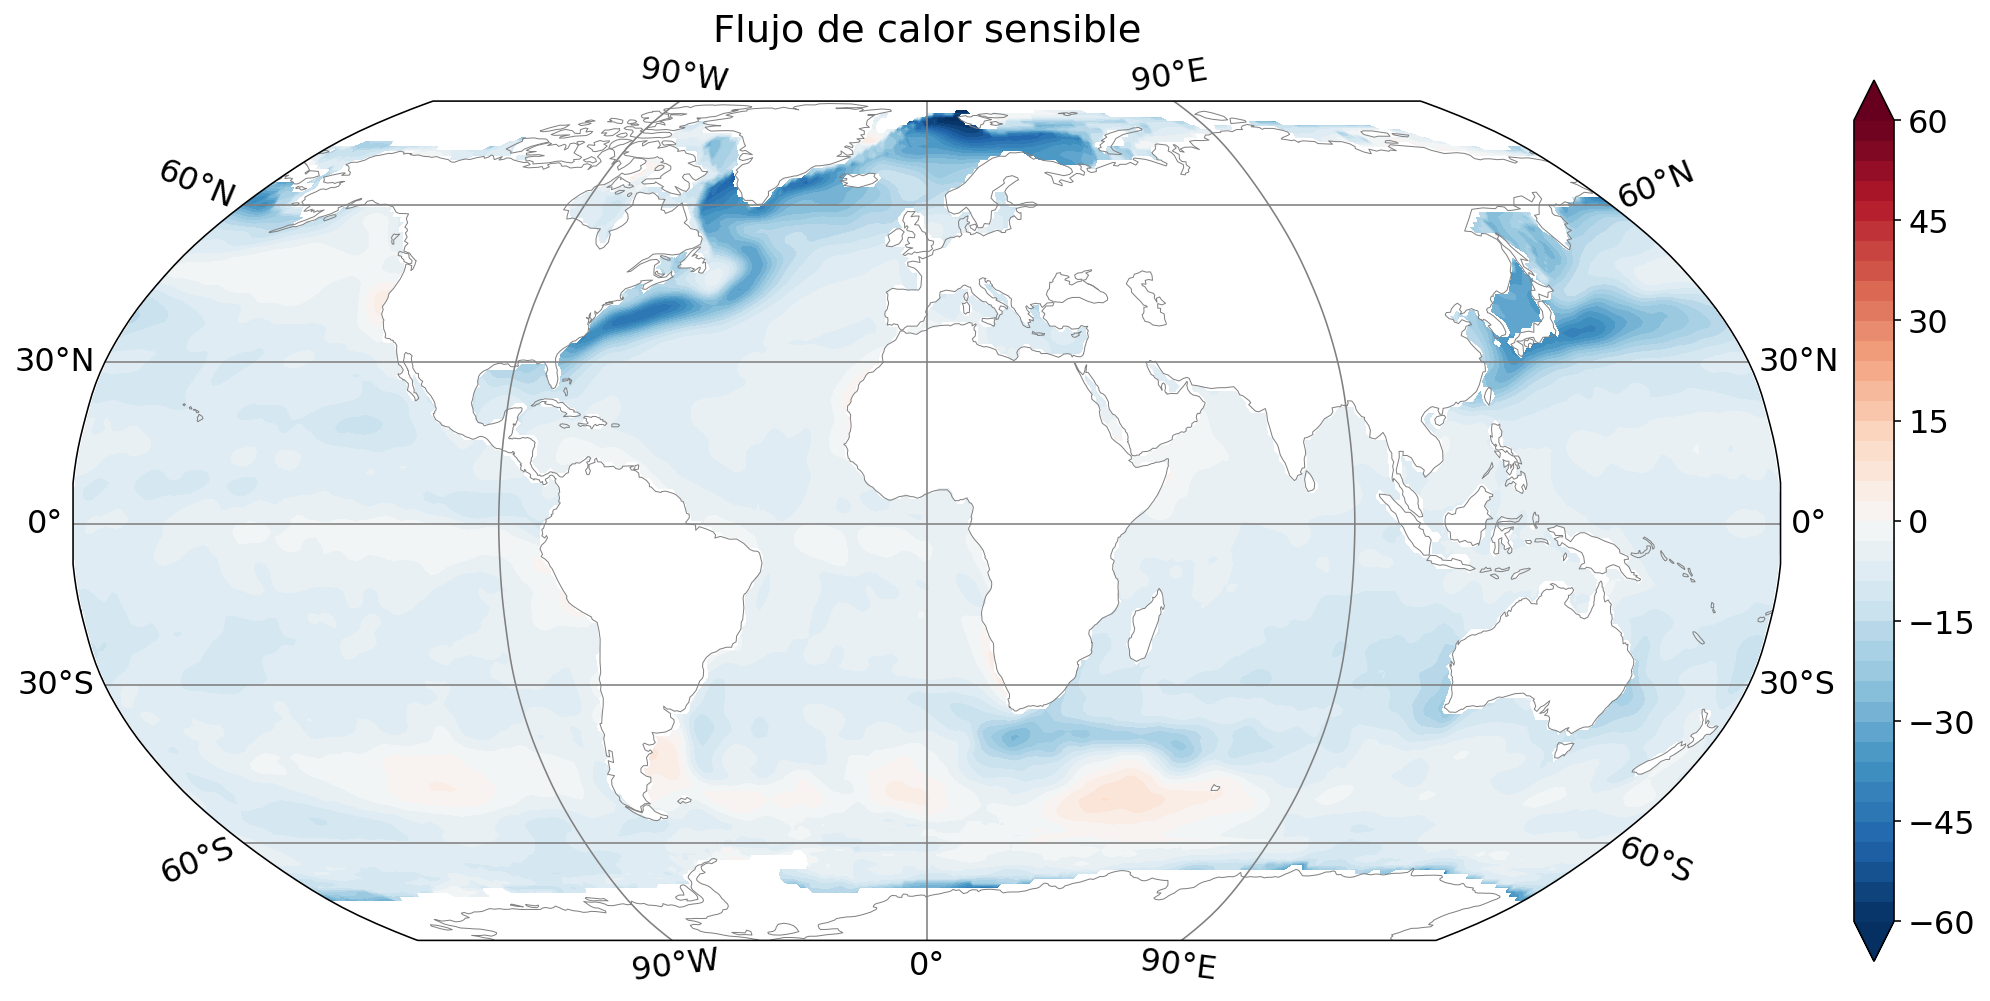

In [15]:
lon = q_sensible.longitude
lat = q_sensible.latitude
values = q_sensible.values
clevs = np.linspace(-60, 60, 41)
crs_latlon = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=ccrs.Robinson())
qplot = ax.contourf(lon, lat, values, cmap='RdBu_r', levels=clevs, transform=crs_latlon, extend='both')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5, color='gray')
grd = ax.gridlines(
    draw_labels=True, 
    xlocs=range(-180, 181, 90), 
    ylocs=range(-60, 61, 30), 
    color='gray',
)
grd.top_labels = False
ax.set_title('Flujo de calor sensible')
plt.colorbar(qplot, fraction=0.03, pad=0.04, shrink=0.8, aspect=20)

### Flujo de calor latente
Este término es el flujo de calor latente que ingresa en la superficie del océano. Se encuentra en unidades de W/m$^2$. Los datos están disponibles para todo el globo y para los 12 meses del año. Para analizar el promedio anual, vamos a sumar el valor de todos los meses y dividirlo por la cantidad de los mismos. De esta manera, nos quedamos con un mapa promedio de todo el año.

In [17]:
q_latente = noca.hfls11a.mean(dim='month')

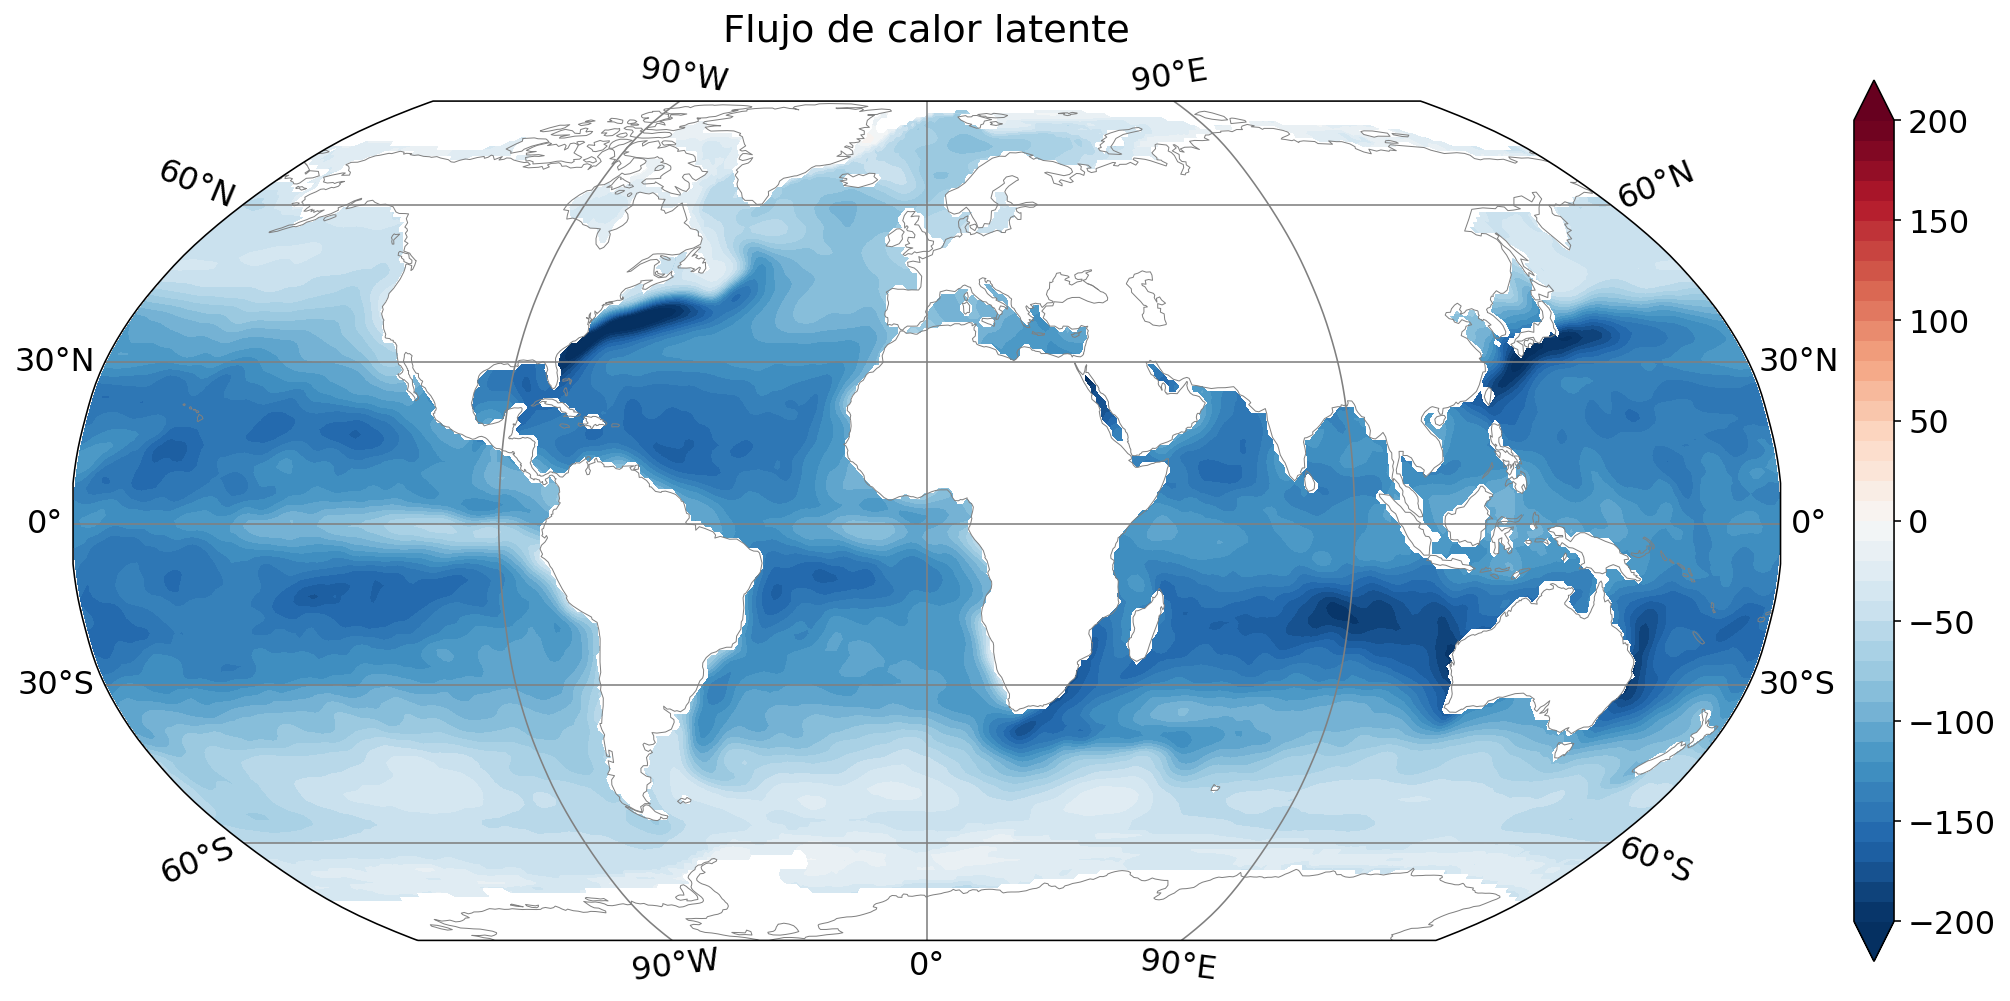

In [18]:
lon = q_latente.longitude
lat = q_latente.latitude
values = q_latente.values
clevs = np.linspace(-200, 200, 41)
crs_latlon = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=ccrs.Robinson())
qplot = ax.contourf(lon, lat, values, cmap='RdBu_r', levels=clevs, transform=crs_latlon, extend='both')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5, color='gray')
grd = ax.gridlines(
    draw_labels=True, 
    xlocs=range(-180, 181, 90), 
    ylocs=range(-60, 61, 30), 
    color='gray',
)
grd.top_labels = False
ax.set_title('Flujo de calor latente')
plt.colorbar(qplot, fraction=0.03, pad=0.04, shrink=0.8, aspect=20)

Cálculo de los promedios zonales

In [19]:
df_zm = noca.fillna(0.).mean(dim=('month', 'longitude')).to_dataframe()
var_names = ['Latente', 'Neto', 'Sensible', 'Onda larga', 'Onda corta']
new_columns = {v: i for v, i in zip(noca.data_vars,var_names)}
df_zm = df_zm.rename(columns=new_columns)

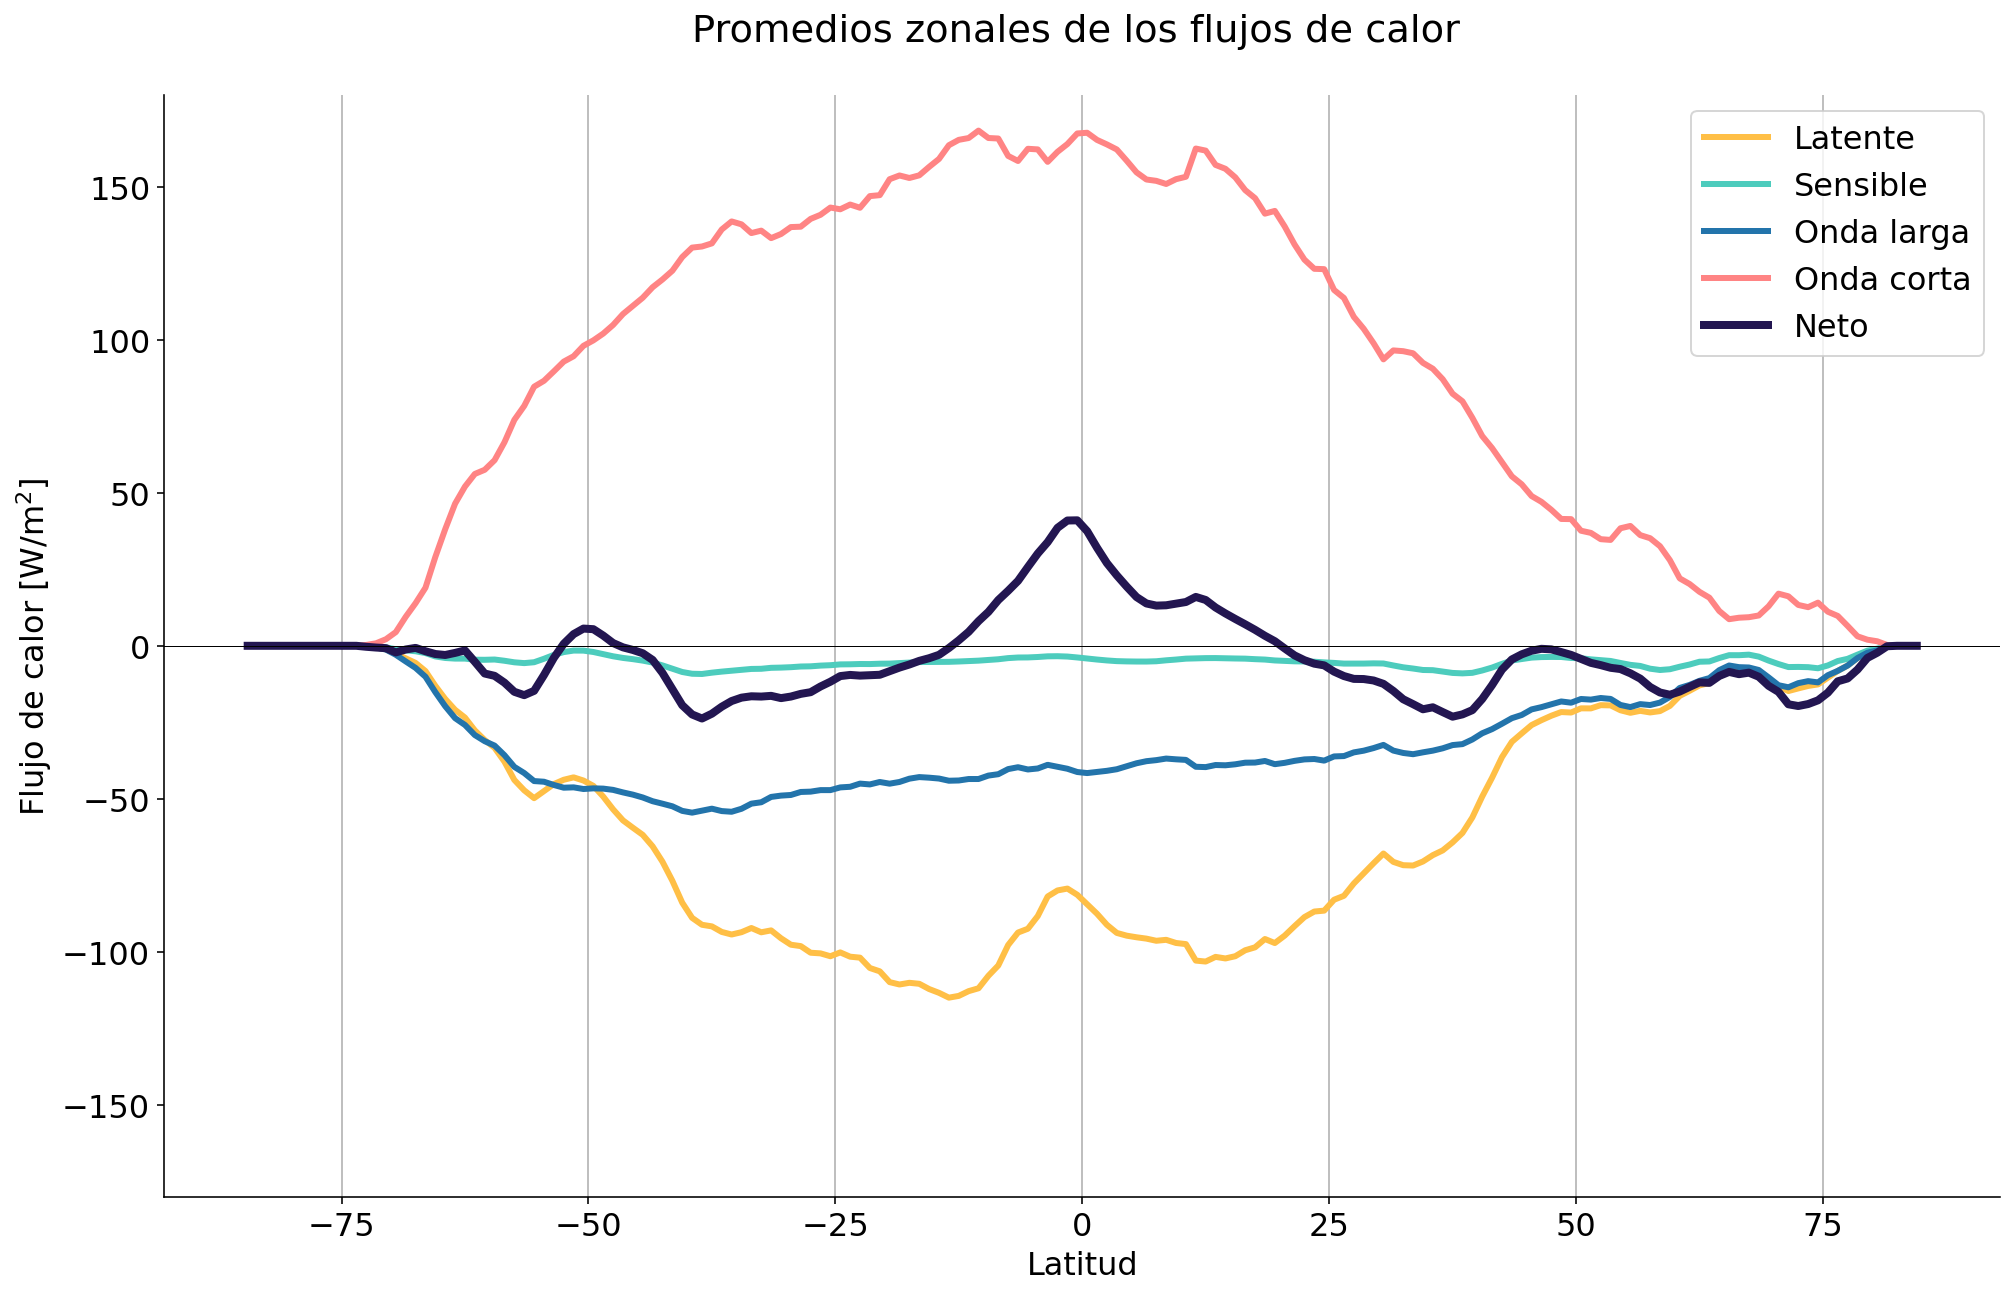

In [20]:
fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85])
df_zm[['Latente', 'Sensible', 'Onda larga', 'Onda corta']].plot(linewidth=3, color=["#ffbf46","#4dccbd","#2374ab","#ff8484"], ax=ax)
df_zm['Neto'].plot(linewidth=4, color="#231651", ax=ax, label='Neto', )
ax.axhline(y=0, color='k', lw=0.5)
ax.set_xlabel('Latitud')
ax.set_ylim([-180, 180])
ax.grid(axis='x')
ax.set_title('Promedios zonales de los flujos de calor \n')
ax.set_ylabel('Flujo de calor [W/m$^2$]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()


## Flujos de sal
Cargamos los datos necesarios para visualizar los flujos de evaporación y precipitación

In [21]:
evap = xr.open_dataset('http://kage.ldeo.columbia.edu:81/expert/home/.OTHER/.richard/.whoi/.oaflux/.data_v3/.monthly/.evaporation/.evapr.nc/dods', decode_times=False)
evap.T.attrs['calendar'] = '360_day'
evap = xr.decode_cf(evap)
evap.load()

<xarray.Dataset>
Dimensions:  (T: 688, lat: 180, lon: 360)
Coordinates:
  * T        (T) object 1958-01-16 00:00:00 ... 2015-04-16 00:00:00
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    evapr    (T, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    history:                   Tue Jul 21 15:45:00 2015: ncatted -a gridtype,...
    nco_openmp_thread_number:  1
    Conventions:               IRIDL
    NCO:                       4.3.7

In [22]:
precip = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods', decode_times=False)
precip.T.attrs['calendar'] = '360_day'
precip = xr.decode_cf(precip)
precip.load()

<xarray.Dataset>
Dimensions:  (T: 360, Y: 72, X: 144)
Coordinates:
  * T        (T) object 1979-01-16 00:00:00 ... 2008-12-16 00:00:00
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    prcp     (T, Y, X) float32 nan nan nan nan ... 0.3158 0.3133 0.3221 0.3301
Attributes:
    Conventions:  IRIDL

In [23]:
evap_mean = evap.mean(dim='T')
precip_mean = precip.mean(dim='T')
precip_i = -360/10*precip_mean.prcp.rename({'X': 'lon', 'Y': 'lat'}).interp_like(evap)
e_minus_p = precip_i + evap_mean.evapr


### Evaporación
A continuación contamos con campos espaciales de evaporación a través de toda la superficie del océano. De los datos disponibles para cada mes se realizó un promedio anual cuyas unidades está en cm/año.

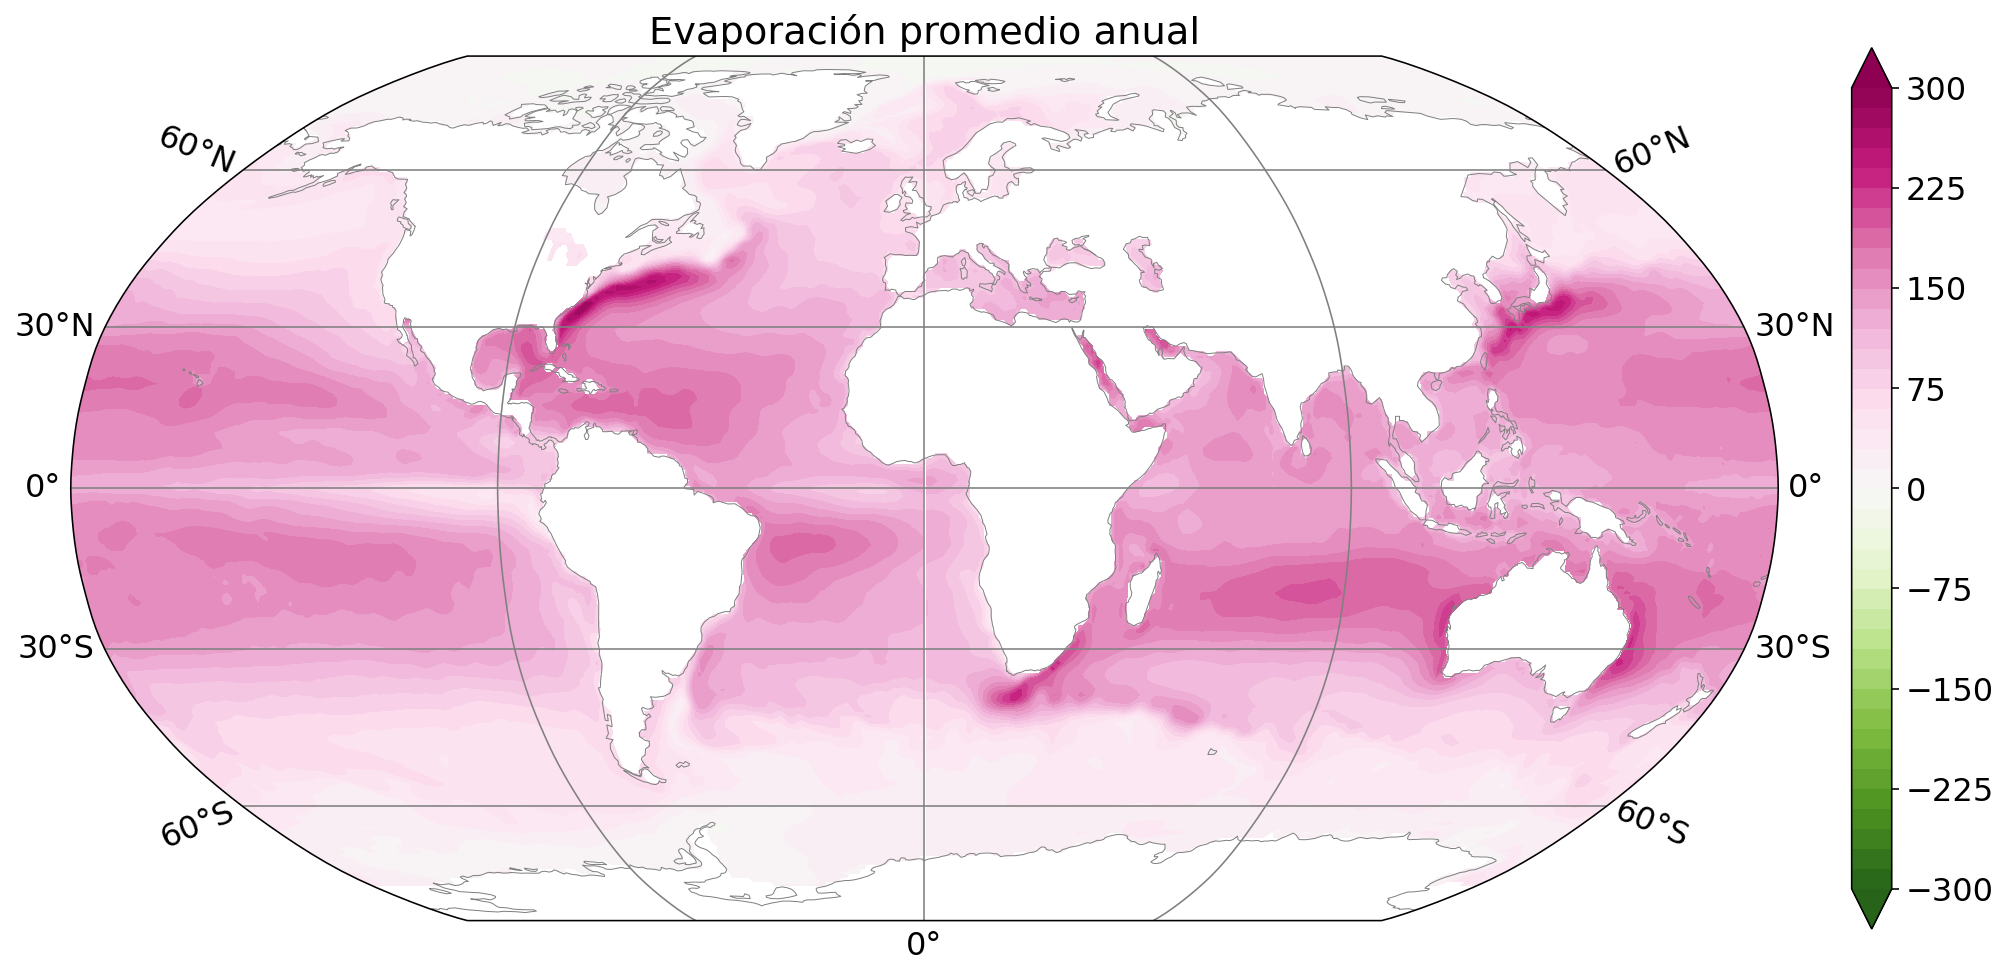

In [24]:
lon = evap_mean.lon
lat = evap_mean.lat
values = evap_mean.evapr.values
clevs = np.linspace(-300, 300, 41)
crs_latlon = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=ccrs.Robinson())
qplot = ax.contourf(lon, lat, values, cmap='PiYG_r', levels=clevs, transform=crs_latlon, extend='both')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5, color='gray')
grd = ax.gridlines(
    draw_labels=True, 
    xlocs=range(-180, 181, 90), 
    ylocs=range(-60, 61, 30), 
    color='gray',
)
grd.top_labels = False
ax.set_title('Evaporación promedio anual')
plt.colorbar(qplot, fraction=0.03, pad=0.04, shrink=0.8, aspect=20)

### Precipitación

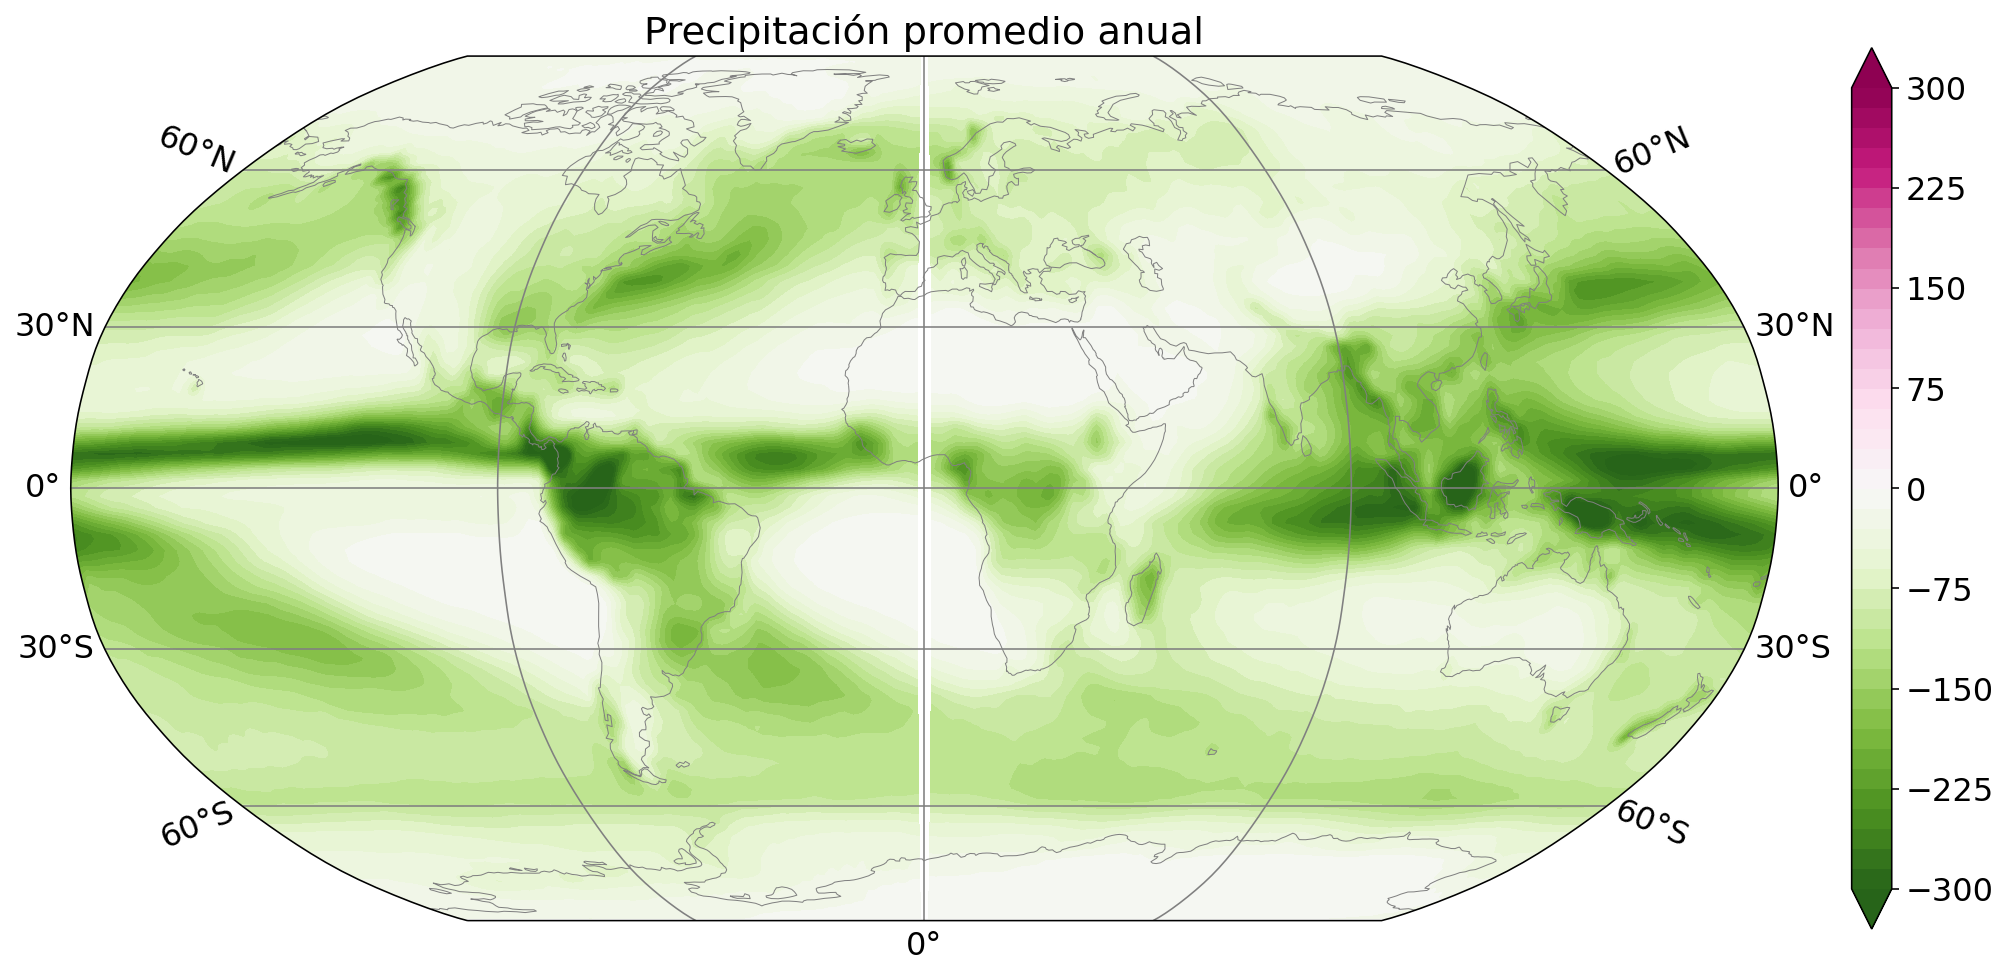

In [25]:
lon = precip_i.lon
lat = precip_i.lat
values = precip_i.values
clevs = np.linspace(-300, 300, 41)
crs_latlon = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=ccrs.Robinson())
qplot = ax.contourf(lon, lat, values, cmap='PiYG_r', levels=clevs, transform=crs_latlon, extend='both')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5, color='gray')
grd = ax.gridlines(
    draw_labels=True, 
    xlocs=range(-180, 181, 90), 
    ylocs=range(-60, 61, 30), 
    color='gray',
)
grd.top_labels = False
ax.set_title('Precipitación promedio anual')
plt.colorbar(qplot, fraction=0.03, pad=0.04, shrink=0.8, aspect=20)

### Evaporación menos Precipitación

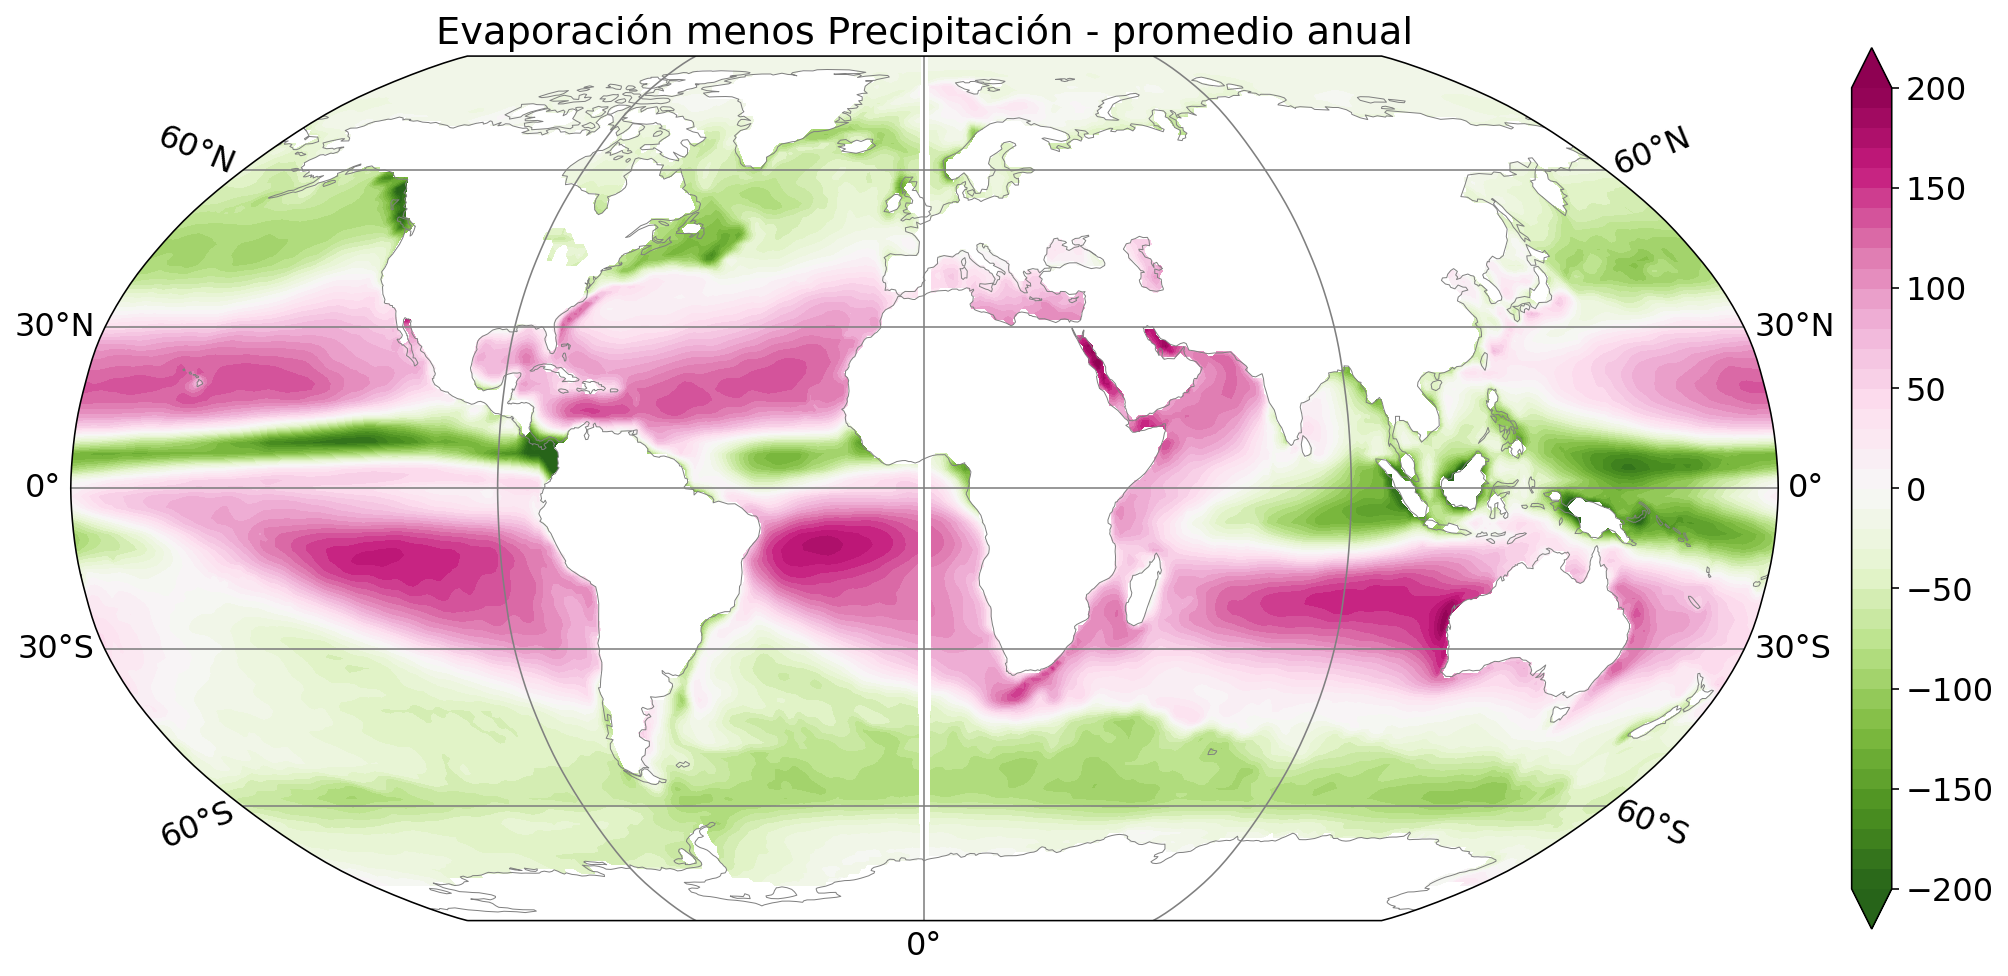

In [26]:
lon = e_minus_p.lon
lat = e_minus_p.lat
values = e_minus_p.values
clevs = np.linspace(-200, 200, 41)
crs_latlon = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=ccrs.Robinson())
qplot = ax.contourf(lon, lat, values, cmap='PiYG_r', levels=clevs, transform=crs_latlon, extend='both')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5, color='gray')
grd = ax.gridlines(
    draw_labels=True, 
    xlocs=range(-180, 181, 90), 
    ylocs=range(-60, 61, 30), 
    color='gray',
)
grd.top_labels = False
ax.set_title('Evaporación menos Precipitación - promedio anual')
plt.colorbar(qplot, fraction=0.03, pad=0.04, shrink=0.8, aspect=20)

Promedios zonales

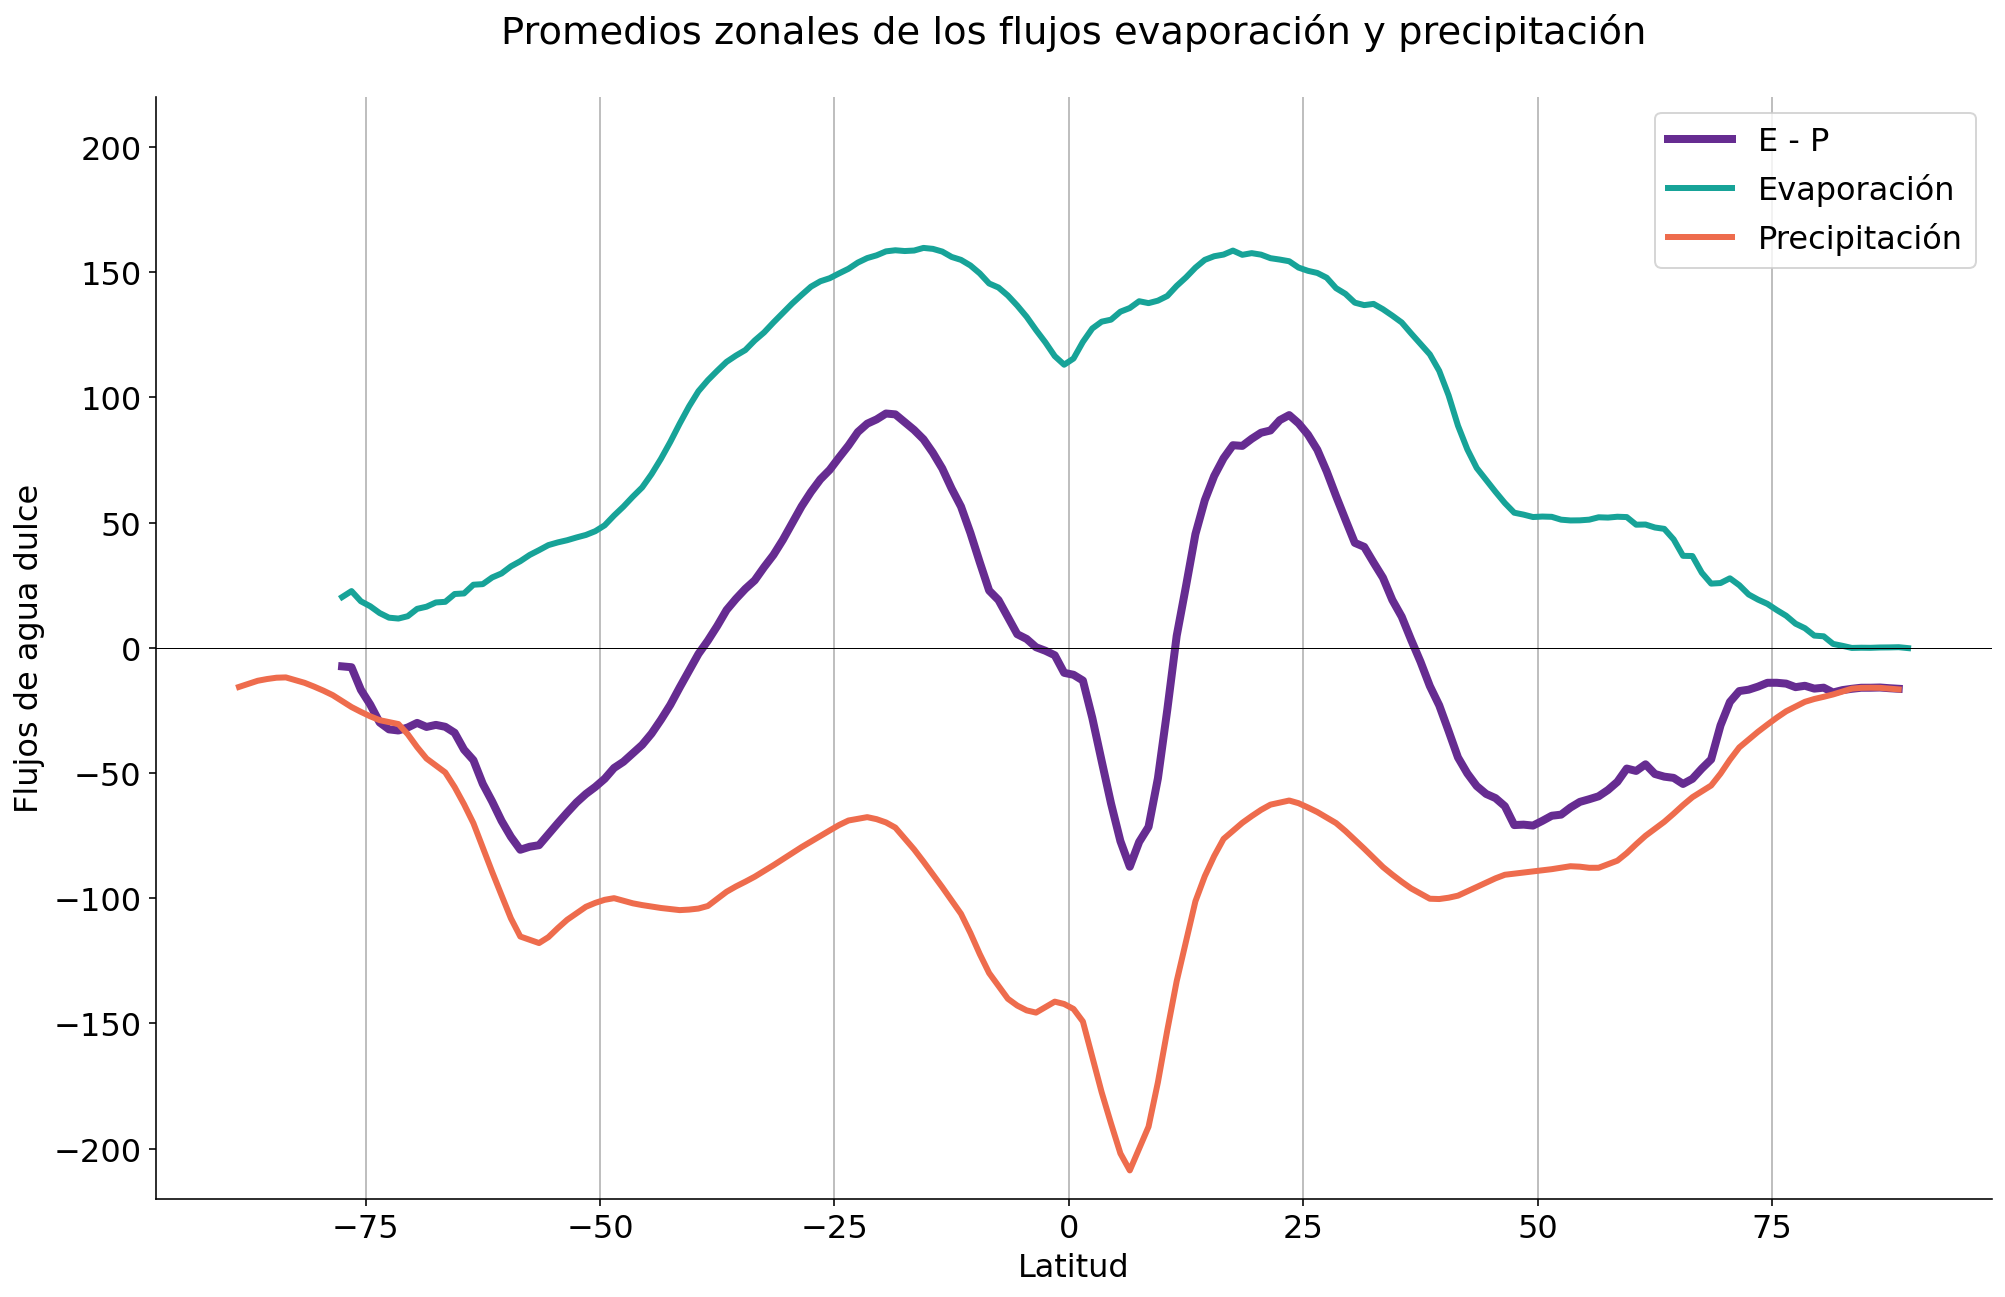

In [27]:
fig = plt.figure()
ax = plt.axes([0.05, 0.05, 0.85, 0.85])

e_minus_p.mean('lon').plot(ax=ax, label='E - P', color='#662C91', lw=4)
evap_mean.evapr.mean('lon').plot(ax=ax, label='Evaporación', color='#17A398', lw=3)
precip_i.mean('lon').plot(ax=ax, label='Precipitación', color='#EE6C4D', lw=3)

ax.axhline(y=0, color='k', lw=0.5)
ax.set_xlabel('Latitud')
ax.set_ylim([-220, 220])
ax.grid(axis='x')
ax.set_ylabel('Flujos de agua dulce')
ax.set_title('Promedios zonales de los flujos evaporación y precipitación\n')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

